In [1]:
import sys
sys.path.append("..")
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from dory.linear.ols import OrdinaryLeastSquares
from dory.scaler.standard import StandardScaler
from dory.linear.gd import GradientDescentRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dory.linear import StochasticGradientDescentRegressor
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
artificial_df = pd.read_csv("artificial1d.csv", header=None)
artificial_df.describe()

,0,1
count,3.000000e+01,30.000000
mean,-2.960595e-17,0.067618
std,6.071316e-01,1.065356
min,-1.000000e+00,-2.082017
25%,-5.000000e-01,-0.870920
50%,0.000000e+00,0.098189
75%,5.000000e-01,0.957162
max,1.000000e+00,2.309838


In [3]:
X = artificial_df.iloc[:, :-1].to_numpy()
y = artificial_df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24, 1) (6, 1) (24,) (6,)


In [4]:
ols_pipeline = Pipeline([
    ("linear", OrdinaryLeastSquares())
])
ols_pipeline

,steps,"[('linear', ...)]"
,transform_input,None
,memory,None
,verbose,False
,fit_intercept,True


/tmp/ipykernel_44234/3597244436.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


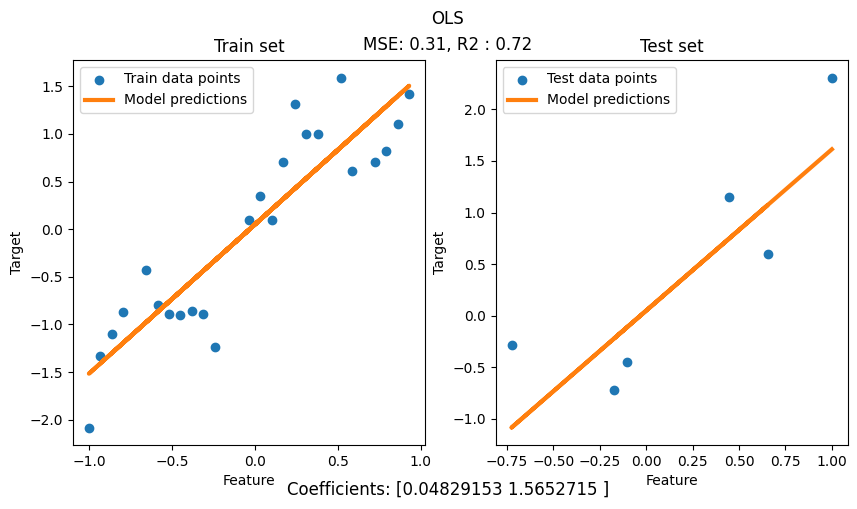

In [5]:
# TODO: Check if this y_pred is normalized and denormalized if needed
y_pred = ols_pipeline.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].scatter(X_train, y_train, label="Train data points")
ax[0].plot(
    X_train,
    ols_pipeline.predict(X_train),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
ax[0].legend()

ax[1].scatter(X_test, y_test, label="Test data points")
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
ax[1].legend()

fig.suptitle("OLS")
fig.text(0.5, 0.9, f'MSE: {mse:.2f}, R2 : {r2:.2f}',fontsize=12, horizontalalignment='center')
fig.text(0.5, 0.01, f'Coefficients: {ols_pipeline.named_steps["linear"].w_}',fontsize=12, horizontalalignment='center')


fig.show()

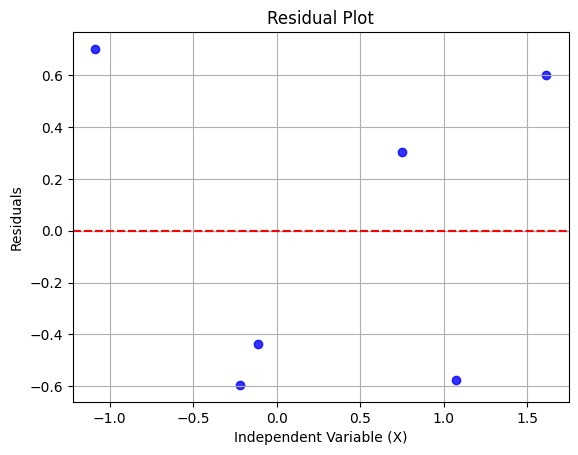

In [6]:
sns.residplot(x=y_pred, y=y_test, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [7]:
epochs = 500
initial_weights = [10.0, 10.0]
gd_pipe = Pipeline(
    [
        (
            "gd",
            GradientDescentRegressor(
                epochs=epochs,
                initial_weights=np.array(initial_weights),
                alpha=0.1,
            ),
        )
    ]
)
gd_pipe

,steps,"[('gd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epochs,500
,epsilon,0.1
,alpha,0.1
,shuffle,True
,seed,42069
,initial_weights,"array([10., 10.])"
,validation_fraction,0.1


INFO:dory.linear.gd:Epoch 0 completed. Train loss: [93.78570894], Val loss: [22.90243995], weights: [[9.19899858 9.82895479]]
INFO:dory.linear.gd:Epoch 1 completed. Train loss: [80.9170141], Val loss: [20.22433217], weights: [[8.46673314 9.65669575]]
INFO:dory.linear.gd:Epoch 2 completed. Train loss: [70.05742243], Val loss: [17.91125287], weights: [[7.79717967 9.48380237]]
INFO:dory.linear.gd:Epoch 3 completed. Train loss: [60.87645246], Val loss: [15.90897724], weights: [[7.18484589 9.3107892 ]]
INFO:dory.linear.gd:Epoch 4 completed. Train loss: [53.09902089], Val loss: [14.1717337], weights: [[6.6247241  9.13811197]]
INFO:dory.linear.gd:Epoch 5 completed. Train loss: [46.49609559], Val loss: [12.66084797], weights: [[6.11224843 8.96617324]]
INFO:dory.linear.gd:Epoch 6 completed. Train loss: [40.8769292], Val loss: [11.34360868], weights: [[5.64325566 8.79532744]]
INFO:dory.linear.gd:Epoch 7 completed. Train loss: [36.08260574], Val loss: [10.19231771], weights: [[5.21394969 8.625885

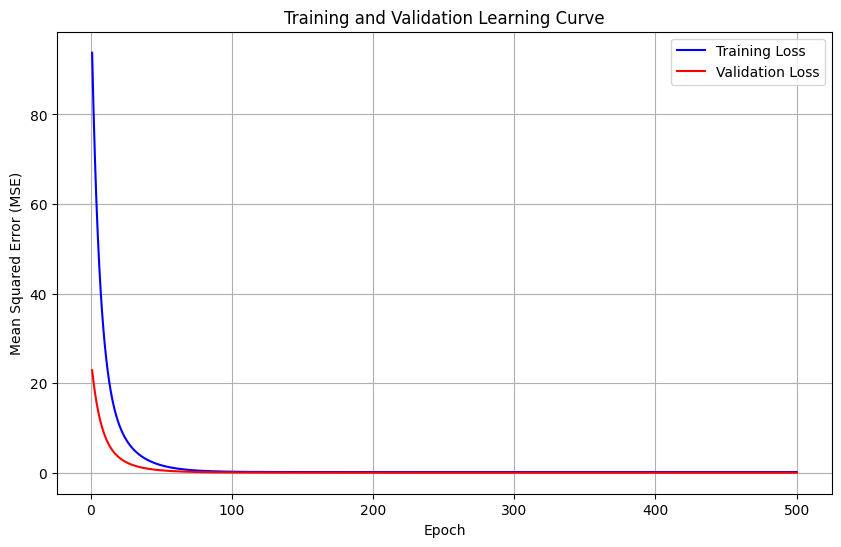

In [8]:
y_pred = gd_pipe.fit(X_train, y_train).predict(X_test)
gd: GradientDescentRegressor = gd_pipe.named_steps["gd"]
mse = mean_squared_error(y_test, y_pred)
epochs_range = range(1, epochs+1)

validation_loss = gd.history_["val_loss"]
train_loss = gd.history_["train_loss"]
validation_loss.describe()
train_loss.describe()

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, validation_loss, label='Validation Loss', color='red')

plt.title('Training and Validation Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

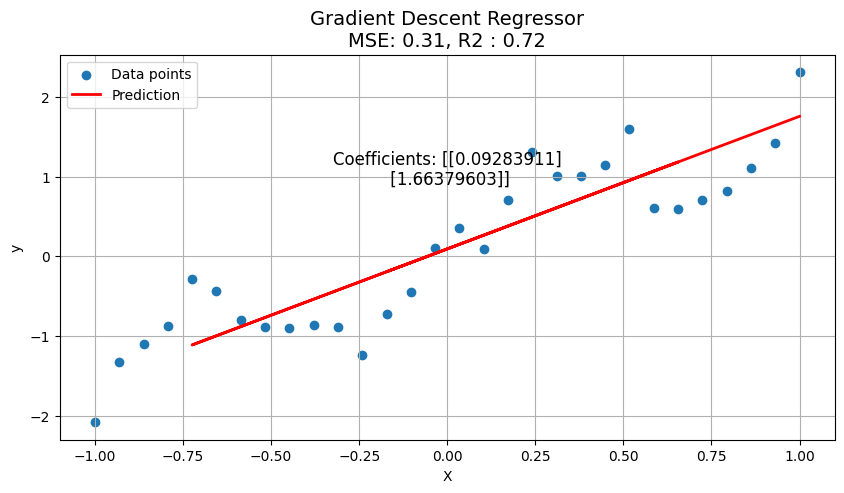

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Data points")
plt.plot(X_test, y_pred, "r-", linewidth=2, label="Prediction")
plt.xlabel("X")
plt.ylabel("y")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.title(f"Gradient Descent Regressor\nMSE: {mse:.2f}, R2 : {r2:.2f}", fontsize=14)
plt.text(0.0, 0.9, f'Coefficients: {gd.weights_}',fontsize=12, horizontalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

In [10]:
sgd_epochs = 100
sgd_pipe = Pipeline(
    [
        (
            "sgd",
            StochasticGradientDescentRegressor(
                epochs=sgd_epochs,
                initial_weights=np.array(initial_weights),
                alpha=0.01,
            ),
        )
    ]
)

sgd_pipe

,steps,"[('sgd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epochs,100
,epsilon,0.1
,alpha,0.01
,shuffle,True
,seed,42069
,initial_weights,"array([10., 10.])"
,validation_fraction,0.1


INFO:dory.linear.sgd:Epoch 0 completed. Train loss: [[52.70884067]], Val loss: 137.89275443739743, weights: [[8.25887678 9.57651876]]
INFO:dory.linear.sgd:Epoch 1 completed. Train loss: [[35.17451768]], Val loss: 105.34788934061244, weights: [[6.84190802 9.15493572]]
INFO:dory.linear.sgd:Epoch 2 completed. Train loss: [[23.66941176]], Val loss: 81.69015659704404, weights: [[5.68740211 8.74025728]]
INFO:dory.linear.sgd:Epoch 3 completed. Train loss: [[16.09398254]], Val loss: 64.26702965504803, weights: [[4.74550192 8.3361631 ]]
INFO:dory.linear.sgd:Epoch 4 completed. Train loss: [[11.08399988]], Val loss: 51.260754721769906, weights: [[3.97590817 7.9452862 ]]
INFO:dory.linear.sgd:Epoch 5 completed. Train loss: [[7.75262014]], Val loss: 41.41697912872243, weights: [[3.3460412  7.56943733]]
INFO:dory.linear.sgd:Epoch 6 completed. Train loss: [[5.52290056]], Val loss: 33.86345938023857, weights: [[2.82955668 7.20978467]]
INFO:dory.linear.sgd:Epoch 7 completed. Train loss: [[4.01907449]], 

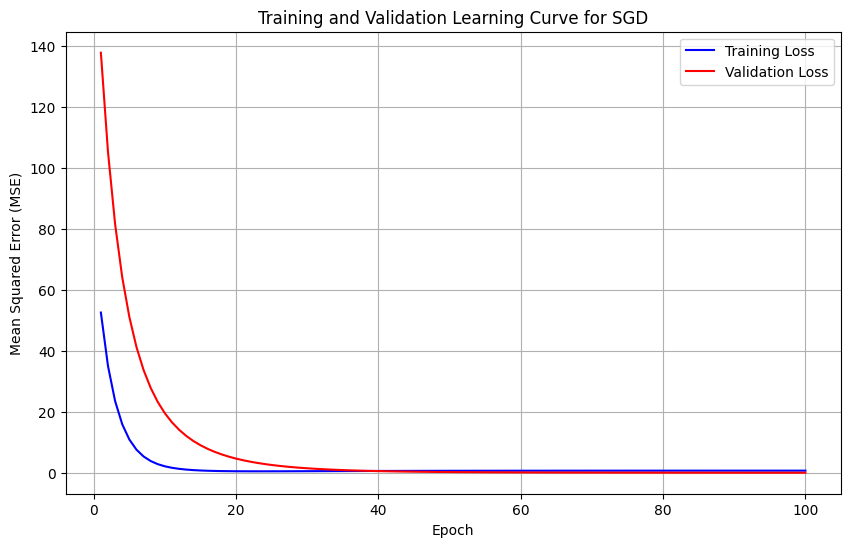

In [11]:
y_pred = sgd_pipe.fit(X_train, y_train).predict(X_test)
sgd: StochasticGradientDescentRegressor = sgd_pipe.named_steps["sgd"]
mse = mean_squared_error(y_test, y_pred)
epochs_range = range(1, sgd_epochs+1)

validation_loss = sgd.history_["val_loss"]
train_loss = sgd.history_["train_loss"]

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, validation_loss, label='Validation Loss', color='red')

plt.title('Training and Validation Learning Curve for SGD')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

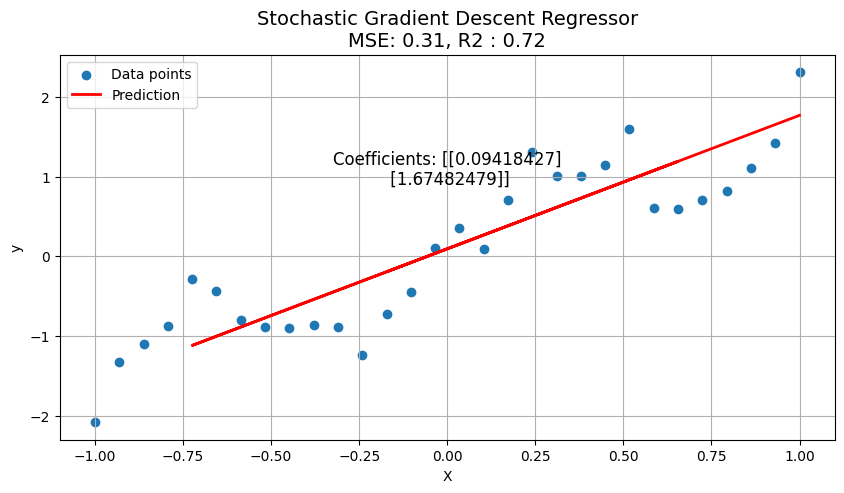

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Data points")
plt.plot(X_test, y_pred, "r-", linewidth=2, label="Prediction")
plt.xlabel("X")
plt.ylabel("y")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.title(f"Stochastic Gradient Descent Regressor\nMSE: {mse:.2f}, R2 : {r2:.2f}", fontsize=14)
plt.text(0.0, 0.9, f'Coefficients: {sgd.weights_}',fontsize=12, horizontalalignment='center')

plt.legend()
plt.grid(True)
plt.show()